In [2]:
import os
import pandas as pd
import numpy as np

# Data

In [3]:
dname = "tcga_ov"
# tests = pd.read_csv(f"../splits/{dname}/splits_0.csv")["test"].dropna().values
# len(tests)

## Clinical

In [4]:
# median filled
cli_df = pd.read_csv(f"./{dname}/clinical_os_data.csv")
print("Nb of missing instances: ", cli_df.isna().sum().sum())
cli_df.shape, cli_df.isna().any().any()

Nb of missing instances:  488


((1231, 24), True)

In [5]:
cli_df.columns

Index(['slide_id', 'case_id', 'hispanic', 'age', 'event', 'survival_months',
       'group', 'grade_binary', 'stage_binary', 'race_asian', 'race_black',
       'race_white', 'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional',
       'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3',
       'clinical_stage_0.0', 'clinical_stage_1.0', 'clinical_stage_2.0',
       'clinical_stage_3.0'],
      dtype='object')

In [8]:
cli_df.drop(columns=["grade_binary"], inplace=True)
cli_df.to_csv(f"../datasets_csv/{dname}.csv", index=False)

## mutations

In [6]:
df = pd.read_csv(f"./{dname}/tcga/data_mutations.txt", sep="\t")
df_woSilent = df[df['Variant_Classification'] != 'Silent']

pivot_df = pd.pivot_table(df_woSilent, values='Variant_Classification', index=['Tumor_Sample_Barcode'], columns=['Hugo_Symbol'], 
                          aggfunc='count', fill_value=0).reset_index()

pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].clip(upper=1)

mut_genes = list(pivot_df.columns[1:])

pivot_df["case_id"] = pivot_df["Tumor_Sample_Barcode"].str.rsplit("-", 1).str[0]
mut_df = pivot_df[["case_id"]+mut_genes].rename(columns={k: k+"_mut" for k in mut_genes}).reset_index(drop=True)
mut_df = mut_df[mut_df["case_id"].isin(cli_df["case_id"].values)]

print(mut_df["case_id"].duplicated().any())
print(mut_df.columns.duplicated().any())
print(mut_df.isna().any().any())
mut_df

False
False
False


Hugo_Symbol,case_id,A1CF_mut,A2M_mut,A2ML1_mut,AACS_mut,AADACL4_mut,AAED1_mut,AAMP_mut,AARS_mut,AARS2_mut,...,ZWILCH_mut,ZXDA_mut,ZXDB_mut,ZXDC_mut,ZYG11B_mut,ZZEF1_mut,ZZZ3_mut,hsa-mir-7162_mut,uc003vym.2_mut,uc003vyo.2_mut
0,TCGA-04-1331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-04-1332,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-04-1336,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-04-1337,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-04-1338,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,TCGA-61-2104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
312,TCGA-61-2109,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,TCGA-61-2110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314,TCGA-61-2111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
mut_df.to_csv(f"../datasets_csv/{dname}_mut.csv.zip", compression="zip", index=False)

## cnv

In [3]:
df = pd.read_csv(f"./{dname}/tcga/data_cna_hg19.seg", sep="\t")
print("Starting:", df.shape)
df = df[df["ID"].str.split("-").str[-1] == "01"]
print("Primary tumors:", df.shape)

,ID,chrom,loc.start,loc.end,num.mark,seg.mean
0,TCGA-04-1331-01,1,3218610,31621427,14810,-0.4925
1,TCGA-04-1331-01,1,31623667,31625389,3,-2.4572
2,TCGA-04-1331-01,1,31627099,32650911,481,-0.4853
3,TCGA-04-1331-01,1,32654393,45934562,7259,0.1771
4,TCGA-04-1331-01,1,45935056,55443633,4852,0.5992
...,...,...,...,...,...,...
211609,TCGA-WR-A838-01,23,62706205,88974207,10725,0.0896
211610,TCGA-WR-A838-01,23,88976824,88981409,2,1.2751
211611,TCGA-WR-A838-01,23,88983271,89075505,39,0.1362
211612,TCGA-WR-A838-01,23,89076376,89076392,2,-1.4289


In [ ]:


duplicated_genes = df["Hugo_Symbol"].duplicated(keep=False)

# Separate duplicates and non-duplicates
df_duplicated = df[duplicated_genes].copy()
df_non_duplicated = df[~duplicated_genes].copy()

# Average the duplicated values
averaged_values = df_duplicated.groupby("Hugo_Symbol").median().reset_index()

df_final = pd.concat([df_non_duplicated, averaged_values], ignore_index=True)
df_final = df_final.sort_values("Hugo_Symbol").reset_index(drop=True)
df_final.drop(columns="Entrez_Gene_Id", inplace=True)
cnv_df = df_final.set_index("Hugo_Symbol").T.reset_index().rename(columns={"index": "case_id"})
cnv_df["case_id"] = cnv_df["case_id"].str.rsplit("-", 1).str[0]

cnv_cols = list(cnv_df.columns[1:])
cnv_df = cnv_df[["case_id"]+ cnv_cols].rename(columns={col: col+"_cnv" for col in cnv_cols})

cnv_df = cnv_df[cnv_df["case_id"].isin(cli_df["case_id"].values)]
print(cnv_df["case_id"].duplicated().any())
print(cnv_df.columns.duplicated().any())
print(cnv_df.isna().any().any())
cnv_df

In [8]:
df = pd.read_csv(f"./{dname}/tcga/data_cna.txt", sep="\t")

duplicated_genes = df["Hugo_Symbol"].duplicated(keep=False)

# Separate duplicates and non-duplicates
df_duplicated = df[duplicated_genes].copy()
df_non_duplicated = df[~duplicated_genes].copy()

# Average the duplicated values
averaged_values = df_duplicated.groupby("Hugo_Symbol").median().reset_index()

df_final = pd.concat([df_non_duplicated, averaged_values], ignore_index=True)
df_final = df_final.sort_values("Hugo_Symbol").reset_index(drop=True)
df_final.drop(columns="Entrez_Gene_Id", inplace=True)
cnv_df = df_final.set_index("Hugo_Symbol").T.reset_index().rename(columns={"index": "case_id"})
cnv_df["case_id"] = cnv_df["case_id"].str.rsplit("-", 1).str[0]

cnv_cols = list(cnv_df.columns[1:])
cnv_df = cnv_df[["case_id"]+ cnv_cols].rename(columns={col: col+"_cnv" for col in cnv_cols})

cnv_df = cnv_df[cnv_df["case_id"].isin(cli_df["case_id"].values)]
print(cnv_df["case_id"].duplicated().any())
print(cnv_df.columns.duplicated().any())
print(cnv_df.isna().any().any())
cnv_df

False
False
False


Hugo_Symbol,case_id,7SK|ENSG00000232512.2_cnv,7SK|ENSG00000249352.3_cnv,7SK|ENSG00000254144.2_cnv,7SK|ENSG00000260682.2_cnv,7SK|ENSG00000271765.1_cnv,7SK|ENSG00000271814.1_cnv,7SK|ENSG00000271818.1_cnv,A1BG_cnv,A1CF_cnv,...,snoZ185_cnv,snoZ247_cnv,snoZ278_cnv,snoZ40_cnv,snoZ5_cnv,snoZ6|ENSG00000252200.1_cnv,snoZ6|ENSG00000253067.1_cnv,snoZ6|ENSG00000264452.1_cnv,snoZ6|ENSG00000266692.1_cnv,snosnR66_cnv
0,TCGA-04-1331,0.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0
1,TCGA-04-1332,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,...,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,TCGA-04-1335,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0
3,TCGA-04-1336,0.0,-1.0,2.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,...,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-04-1337,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,TCGA-61-2614,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,...,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
575,TCGA-OY-A56P,0.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,1.0
576,TCGA-OY-A56Q,0.0,-1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,2.0,-1.0,0.0,0.0,-1.0
577,TCGA-VG-A8LO,0.0,-1.0,2.0,-1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
cnv_df.to_csv(f"../datasets_csv/{dname}_cnv.csv.zip", compression="zip", index=False)

## rnaseq

In [10]:
df = pd.read_csv(f"./{dname}/tcga/data_mrna_seq_v2_rsem.txt", sep="\t")
duplicated_genes = df["Hugo_Symbol"].duplicated(keep=False)

# Separate duplicates and non-duplicates
df_duplicated = df[duplicated_genes].copy()
df_non_duplicated = df[~duplicated_genes].copy()

# Average the duplicated values
averaged_values = df_duplicated.groupby("Hugo_Symbol").mean().reset_index()

df_final = pd.concat([df_non_duplicated, averaged_values], ignore_index=True)
df_final = df_final.sort_values("Hugo_Symbol").reset_index(drop=True)

recurrent_tm = [i for i in df_final.columns[2:] if i.rsplit("-")[-1] != "01"]
df_final.drop(columns="Entrez_Gene_Id", inplace=True)
df_final = df_final.drop(columns=recurrent_tm)
df_final = df_final.drop(df_final.index[df_final["Hugo_Symbol"].isna()])
df_cases = df_final.set_index("Hugo_Symbol").T.reset_index().rename(columns={"index": "case_id"})
df_cases["case_id"] = df_cases["case_id"].str.rsplit("-", 1).str[0]
rna_genes = list(df_cases.columns[1:])
rna_df = df_cases[["case_id"]+ rna_genes].rename(columns={col: col+"_rna" for col in rna_genes})
rna_df = rna_df[rna_df["case_id"].isin(cli_df["case_id"].values)]

print(rna_df["case_id"].duplicated().any())
print(rna_df.columns.duplicated().any())
print(rna_df.isna().any().any())

rna_df

False
False
False


Hugo_Symbol,case_id,133K02_rna,5T4_rna,A-C1_rna,A1BG_rna,A1BG-AS1_rna,A1CF_rna,A2M_rna,A2M-AS1_rna,A2ML1_rna,...,ZWILCH_rna,ZWINT_rna,ZWS1_rna,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZZ3_rna
0,TCGA-04-1348,431.8365,331.8096,97.6069,66.4695,36.3243,0.000,5899.8279,118.4566,7.5289,...,928.9002,794.5684,373.7564,36.0312,235.2783,827.1041,5.6467,560.0968,15871.2019,475.9344
2,TCGA-04-1362,386.5598,1007.1073,90.6827,41.6412,23.2465,0.331,3350.4207,71.3613,5.6263,...,421.6182,605.3235,385.8978,93.3304,788.6746,1575.0325,56.5939,915.7627,6137.2982,803.8987
3,TCGA-04-1364,334.9785,345.5791,100.4936,187.0368,114.6008,0.000,1455.2316,67.8607,5.0883,...,913.9953,1079.9878,661.9006,13.9928,137.3836,1138.5030,13.1447,811.5809,5972.3706,444.8006
4,TCGA-04-1365,277.2337,483.9536,46.7078,23.9295,10.4957,0.000,3999.3792,52.1501,3.3148,...,646.5632,1882.7784,312.7919,35.8596,328.4617,1455.7782,7.2322,1031.7915,7211.9934,787.1026
5,TCGA-04-1514,316.0622,114.2775,24.1796,32.8123,20.1900,0.000,3224.5797,224.7582,3.7421,...,556.5630,1082.3258,483.0167,126.6552,959.1249,965.1698,20.4375,1082.6137,5867.2855,1149.1077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,TCGA-61-2113,261.0291,2215.4276,49.2706,70.4394,106.1623,0.000,5365.7972,23.5625,2.4461,...,540.3477,458.1113,584.2579,23.4122,159.3431,1277.1905,117.0612,776.4480,6787.8047,972.1324
299,TCGA-OY-A56P,226.8219,514.5571,35.7999,43.1736,47.8864,0.000,8773.5936,84.2153,98.3162,...,325.1728,303.2307,981.5590,99.3849,637.4523,2368.4052,28.5865,2075.0596,10157.0254,2826.3236
300,TCGA-OY-A56Q,169.9434,376.8744,25.3249,33.6854,25.3482,0.000,10006.7877,582.3492,269.5768,...,392.0826,625.4582,744.4185,48.9837,298.2339,1854.3819,119.6268,1157.2809,10968.3439,2466.5112
301,TCGA-VG-A8LO,291.8109,168.7737,34.1412,27.9604,17.9853,0.000,1888.1746,59.8084,4.5092,...,824.4915,602.6250,493.1154,72.4696,492.1491,1916.4184,6.4417,1528.9476,8124.0035,1297.3669


In [11]:
rna_df.to_csv(f"../datasets_csv/{dname}_rna.csv.zip", compression="zip", index=False)

## rna - z scores

In [20]:
df = pd.read_csv(f"./{dname}/tcga/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
print("Initially: ", df.shape)
duplicated_genes = df["Hugo_Symbol"].duplicated(keep=False)

# Separate duplicates and non-duplicates
df_duplicated = df[duplicated_genes].copy()
df_non_duplicated = df[~duplicated_genes].copy()

# Average the duplicated values
averaged_values = df_duplicated.groupby("Hugo_Symbol").mean().reset_index()

df_final = pd.concat([df_non_duplicated, averaged_values], ignore_index=True)
df_final = df_final.sort_values("Hugo_Symbol").reset_index(drop=True)
print("Duplicated genes are removed: ", df_final.shape)
recurrent_tm = [i for i in df_final.columns[2:] if i.rsplit("-")[-1] != "01"]
df_final.drop(columns="Entrez_Gene_Id", inplace=True)
df_final = df_final.dropna(thresh=int(df_final.shape[1]*.8))
print("Mising >.8 genes are removed: ", df_final.shape)
df_final = df_final.drop(columns=recurrent_tm)
print("Recurrent tms are removed: ", df_final.shape)
df_final = df_final.drop(df_final.index[df_final["Hugo_Symbol"].isna()])
df_cases = df_final.set_index("Hugo_Symbol").T.reset_index().rename(columns={"index": "case_id"})
df_cases["case_id"] = df_cases["case_id"].str.rsplit("-", 1).str[0]
rna_genes = list(df_cases.columns[1:])
rna_df = df_cases[["case_id"]+ rna_genes].rename(columns={col: col+"_rnz" for col in rna_genes})
rna_df = rna_df[rna_df["case_id"].isin(cli_df["case_id"].values)]
print("Matched image data is available: ", df_final.shape)
print(rna_df["case_id"].duplicated().any())
print(rna_df.columns.duplicated().any())
print(rna_df.isna().any().any())

rna_df

Initially:  (20531, 309)
Duplicated genes are removed:  (20516, 309)
Mising >.8 genes are removed:  (20100, 308)
Recurrent tms are removed:  (20100, 304)
Matched image data is available:  (20099, 304)
False
False
False


Hugo_Symbol,case_id,133K02_rnz,5T4_rnz,A-C1_rnz,A1BG_rnz,A1BG-AS1_rnz,A1CF_rnz,A2M_rnz,A2M-AS1_rnz,A2ML1_rnz,...,ZWILCH_rnz,ZWINT_rnz,ZWS1_rnz,ZXDA_rnz,ZXDB_rnz,ZXDC_rnz,ZYG11A_rnz,ZYG11B_rnz,ZYX_rnz,ZZZ3_rnz
0,TCGA-04-1348,1.2747,-0.6031,0.6800,-0.2755,-0.3252,-0.8614,0.1003,0.6593,-0.4802,...,1.9467,0.3888,-0.2028,-1.3684,-1.5560,-1.4080,-1.0251,-1.1571,1.4922,-1.6281
2,TCGA-04-1362,0.9340,0.6022,0.5930,-0.8198,-0.8408,-0.4239,-0.8077,-0.1423,-0.6203,...,-0.0599,-0.0849,-0.1133,0.6813,1.5055,0.8259,0.7016,0.2988,-0.6793,-0.1384
3,TCGA-04-1364,0.4936,-0.5590,0.7145,0.9401,1.0260,-0.8614,-2.1455,-0.2215,-0.6673,...,1.9056,0.9233,1.3978,-3.3506,-2.9134,-0.2999,-0.4212,-0.0589,-0.7415,-1.8202
4,TCGA-04-1365,-0.0879,-0.1937,-0.1877,-1.4564,-1.7328,-0.8614,-0.5236,-0.6356,-0.8585,...,1.0260,1.8917,-0.7011,-1.3786,-0.7125,0.5527,-0.8540,0.6523,-0.3105,-0.1984
5,TCGA-04-1514,0.3149,-1.7561,-0.9514,-1.0949,-1.0019,-0.8614,-0.8691,1.6770,-0.8061,...,0.6452,0.9271,0.5152,1.3445,2.0014,-0.8727,-0.0887,0.7947,-0.7821,0.8775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,TCGA-61-2113,-0.2729,1.4589,-0.1252,-0.2077,0.9354,-0.8614,-0.0519,-1.8699,-0.9833,...,0.5701,-0.5698,1.0482,-2.2819,-2.5397,0.0988,1.2756,-0.1900,-0.4490,0.4018
299,TCGA-OY-A56P,-0.7042,-0.1271,-0.4979,-0.7779,-0.0027,-0.8614,0.7371,0.1192,0.8827,...,-0.7190,-1.2873,2.5023,0.8177,0.9662,2.2412,0.1690,2.7228,0.4721,3.4378
300,TCGA-OY-A56Q,-1.5898,-0.4650,-0.8983,-1.0647,-0.7415,-0.8614,0.9482,3.1950,1.4392,...,-0.2442,-0.0279,1.7271,-0.7109,-0.9566,1.3923,1.2928,0.9923,0.6477,3.0503
301,TCGA-VG-A8LO,0.0696,-1.3351,-0.5531,-1.2786,-1.1332,-0.8614,-1.7277,-0.4204,-0.7228,...,1.6437,-0.0927,0.5731,0.1334,0.3110,1.5065,-0.9348,1.8176,-0.0383,1.2226


In [21]:
rna_df.to_csv(f"../datasets_csv/{dname}_rnz.csv.zip", compression="zip", index=False)

## pro

In [22]:
df = pd.read_csv(f"./{dname}/tcga/data_rppa.txt", sep="\t")
print(df["Composite.Element.REF"].duplicated(keep=False).any())
df_final = df.sort_values("Composite.Element.REF").reset_index(drop=True)

recurrent_tm = [i for i in df_final.columns[2:] if i.rsplit("-")[-1] != "01"]
print(df_final.shape)
print("Recurrent tumors: ", len(recurrent_tm))
df_final = df_final.drop(columns=recurrent_tm)
print(df_final.shape)
df_final = df_final.drop(df_final.index[df_final["Composite.Element.REF"].isna()])
print(df_final.shape)
df_clean = df_final.dropna(thresh=int(df_final.shape[1]*.8))
print("After removing empty proteins in > 80%: ", df_clean.shape)
df_cases = df_clean.set_index("Composite.Element.REF").T.reset_index().rename(columns={"index": "case_id"})
df_cases["case_id"] = df_cases["case_id"].str.rsplit("-", 1).str[0]

pro_genes = list(df_cases.columns[1:])
pro_df = df_cases[["case_id"]+ pro_genes].rename(columns={col: col+"_pro" for col in pro_genes})
pro_df = pro_df[pro_df["case_id"].isin(cli_df["case_id"].values)]
print("Cases with cli data: ", pro_df.shape)
print(pro_df["case_id"].duplicated().any())
print(pro_df.columns.duplicated().any())
print(pro_df.isna().any().any())

pro_df

False
(208, 437)
Recurrent tumors:  11
(208, 426)
(208, 426)
After removing empty proteins in > 80%:  (204, 426)
Cases with cli data:  (414, 205)
False
False
True


Composite.Element.REF,case_id,ACACA ACACB|ACC_pS79_pro,ACACA|ACC1_pro,ACVRL1|ACVRL1_pro,AKT1 AKT2 AKT3|Akt_pro,AKT1 AKT2 AKT3|Akt_pS473_pro,AKT1 AKT2 AKT3|Akt_pT308_pro,AKT1S1|PRAS40_pT246_pro,ANXA1|Annexin-1_pro,ANXA7|Annexin_VII_pro,...,XBP1|XBP1_pro,XRCC1|XRCC1_pro,XRCC5|Ku80_pro,YAP1|YAP_pro,YAP1|YAP_pS127_pro,YBX1|YB-1_pro,YBX1|YB-1_pS102_pro,YWHAB|14-3-3_beta_pro,YWHAE|14-3-3_epsilon_pro,YWHAZ|14-3-3_zeta_pro
0,TCGA-04-1335,0.050157,0.338735,0.028899,-0.362076,1.902311,1.241415,-0.128162,0.415967,0.045857,...,0.457778,-0.612430,0.273903,-0.246701,0.053472,0.234894,-0.110302,-0.008553,0.059854,-0.040743
1,TCGA-04-1336,-0.122685,-0.514174,-0.072171,0.124800,0.118800,0.036025,-0.068028,-0.600145,-0.070430,...,0.124803,-0.026779,-0.016853,-0.082328,0.424904,-0.322371,-0.106064,-0.115064,-0.075638,0.466381
2,TCGA-04-1338,-0.788799,-0.684709,0.265096,-0.116073,0.339617,0.454237,-0.418403,0.269226,0.147967,...,0.185344,-0.147648,-0.454878,0.415796,-0.049777,-0.204733,-0.283831,0.182304,0.255061,0.500384
3,TCGA-04-1341,0.544080,0.482856,0.474257,-0.160586,0.590164,0.227633,0.259963,-0.180727,0.128443,...,0.066478,0.025270,-0.266316,-0.361657,0.345984,0.413982,0.746081,0.184517,0.032904,0.126560
4,TCGA-04-1342,0.291188,0.317670,0.169391,-0.319387,1.022617,0.570207,-0.071549,-0.381018,0.073137,...,0.938900,-0.108158,-0.158992,-0.193000,0.300835,0.797873,-0.160503,-0.020604,-0.134749,-0.273026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,TCGA-61-2614,0.294133,0.042560,-0.072756,-0.003160,0.807530,0.453940,0.137475,0.124468,-0.065395,...,-0.042419,-0.282149,0.052371,-0.333259,-0.507655,0.086028,-0.002333,-0.277144,-0.066282,-0.476036
421,TCGA-OY-A56P,0.678777,0.746679,-0.136984,-0.508459,-0.097865,-0.177417,0.148403,0.210075,-0.120179,...,0.034178,0.389113,-0.013918,0.588104,0.698385,0.463170,-0.131119,-0.140199,-0.069463,-0.157745
422,TCGA-OY-A56Q,0.069934,-0.019771,-0.088824,-0.042172,0.078807,-0.063589,0.235932,0.683164,0.330481,...,-0.053597,0.891833,0.170997,0.341120,0.716418,-0.088501,-0.041030,-0.085609,0.089297,0.261936
423,TCGA-VG-A8LO,0.116778,-0.085238,-0.027367,-0.176764,0.325561,0.058855,0.120482,0.470819,0.367324,...,0.270166,-0.315340,-0.263736,0.262682,0.413353,-0.274155,-0.104356,0.029152,0.069522,0.189983


In [23]:
pro_df.to_csv(f"../datasets_csv/{dname}_pro.csv.zip", compression="zip", index=False)

## dna

In [5]:
df = pd.read_csv(f"./{dname}/tcga/data_methylation_hm27.txt", sep="\t")
duplicated_genes = df["Hugo_Symbol"].duplicated(keep=False)

# Separate duplicates and non-duplicates
df_duplicated = df[duplicated_genes].copy()
df_non_duplicated = df[~duplicated_genes].copy()

# Average the duplicated values
averaged_values = df_duplicated.groupby("Hugo_Symbol").mean().reset_index()

df_final = pd.concat([df_non_duplicated, averaged_values], ignore_index=True)
df_final = df_final.sort_values("Hugo_Symbol").reset_index(drop=True)
print(df_final.shape)

df_clean = df_final.dropna(thresh=int(df_final.shape[1]*.8))
print(df_clean.shape)
recurrent_tm = [i for i in df_final.columns[2:] if i.rsplit("-")[-1] != "01"]
print(len(recurrent_tm))
df_clean = df_clean.drop(columns=recurrent_tm)
df_clean = df_clean.drop(df_clean.index[df_clean["Hugo_Symbol"].isna()])
print(df_clean.shape)

df_cases = df_clean.set_index("Hugo_Symbol").T.reset_index().rename(columns={"index": "case_id"})
print(df_cases.columns.duplicated().any())
df_cases["case_id"] = df_cases["case_id"].str.rsplit("-", 1).str[0]
dna_genes = list(df_cases.columns[1:])
dna_df = df_cases[["case_id"]+ dna_genes].rename(columns={col: col+"_dna" for col in dna_genes})
dna_df = dna_df[dna_df["case_id"].isin(cli_df["case_id"].values)]
print("Cases with cli data: ", dna_df.shape)
print(dna_df["case_id"].duplicated().any())
print(dna_df.columns.duplicated().any())
print(dna_df.isna().any().any())
dna_df

(14874, 593)
(14373, 593)
12
(14373, 581)
False
Cases with cli data:  (559, 14374)
False
False
True


Hugo_Symbol,case_id,A1BG_dna,A1CF_dna,A2BP1_dna,A2M_dna,A2ML1_dna,A4GALT_dna,A4GNT_dna,AAAS_dna,AACS_dna,...,ZSWIM1_dna,ZSWIM3_dna,ZSWIM7_dna,ZUFSP_dna,ZW10_dna,ZWILCH_dna,ZWINT_dna,ZYX_dna,ZZEF1_dna,ZZZ3_dna
0,TCGA-04-1331,0.981805,0.816419,0.196513,0.582584,0.469370,0.269578,0.806530,0.067518,0.098671,...,0.049296,0.448896,0.026618,0.034261,0.021411,0.048051,0.014654,0.012361,0.015735,0.018789
1,TCGA-04-1332,0.982110,0.565820,0.022767,0.552774,0.829701,0.296869,0.700986,0.057805,0.017430,...,0.038076,0.182496,0.015868,0.029626,0.022453,0.047327,0.013715,0.012677,0.011100,0.025092
2,TCGA-04-1335,0.957049,0.603784,0.681104,0.394409,0.669948,0.249889,0.820301,0.118457,0.011785,...,0.284387,0.393827,0.034591,0.134409,0.023022,0.046214,0.014255,0.008811,0.024669,0.072879
3,TCGA-04-1336,0.952807,NaN,0.009456,0.466297,0.228725,0.386736,0.489553,0.083912,0.011477,...,0.347038,0.401215,0.032352,0.052731,0.025746,0.033919,0.014425,0.013426,0.014864,0.046425
4,TCGA-04-1337,0.986589,0.698739,0.170477,0.667076,0.896899,0.339014,0.928064,0.049442,0.034056,...,0.022741,0.387501,0.019475,0.022706,0.017513,0.034557,0.012591,0.012550,0.011353,0.016047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,TCGA-61-2111,0.954911,0.268565,0.390809,0.805110,0.733029,0.080300,0.619909,0.150095,0.011890,...,0.037573,0.031485,0.022357,0.014230,0.010066,0.034627,0.014369,0.007447,0.015375,0.013467
566,TCGA-61-2113,0.949360,0.571589,0.131924,0.809480,0.430048,0.172873,0.375198,0.125191,0.087687,...,0.060467,0.137753,0.038985,0.018988,0.018274,0.045965,0.017367,0.010630,0.021257,0.025499
567,TCGA-61-2612,0.921891,0.815743,0.240453,0.902233,0.535340,0.331119,0.868159,0.114558,0.177753,...,0.066533,0.266707,0.026484,0.025178,0.037937,0.045864,0.034713,0.116062,0.040508,0.054314
568,TCGA-61-2613,0.928122,0.834670,0.071404,0.762165,0.549529,0.292376,0.895432,0.099741,0.014708,...,0.100164,0.036415,0.043217,0.038979,0.034316,0.032903,0.025793,0.162768,0.063007,0.045219


In [6]:
(dna_df[[col+"_dna" for col in dna_genes]] == 0).any().any()

False

In [7]:
dna_df.to_csv(f"../datasets_csv/{dname}_dna.csv.zip", compression="zip", index=False)

## DFS files

In [1]:
import pandas as pd
cli_df = pd.read_csv("../datasets_csv/tcga_ov_dfs.csv")
print(cli_df.shape)
rna_df = pd.read_csv("../datasets_csv/tcga_ov_rna.csv.zip", compression="zip")
pro_df = pd.read_csv("../datasets_csv/tcga_ov_pro.csv.zip", compression="zip")
dna_df = pd.read_csv("../datasets_csv/tcga_ov_dna.csv.zip", compression="zip")
mut_df = pd.read_csv("../datasets_csv/tcga_ov_mut.csv.zip", compression="zip")
cnv_df = pd.read_csv("../datasets_csv/tcga_ov_cnv.csv.zip", compression="zip")

print(rna_df.shape, pro_df.shape, dna_df.shape, mut_df.shape, cnv_df.shape)
rna_df = rna_df[rna_df["case_id"].isin(cli_df["case_id"].values)]
pro_df = pro_df[pro_df["case_id"].isin(cli_df["case_id"].values)]
dna_df = dna_df[dna_df["case_id"].isin(cli_df["case_id"].values)]
mut_df = mut_df[mut_df["case_id"].isin(cli_df["case_id"].values)]
cnv_df = cnv_df[cnv_df["case_id"].isin(cli_df["case_id"].values)]

print(rna_df.shape, pro_df.shape, dna_df.shape, mut_df.shape, cnv_df.shape)
rna_df.to_csv("../datasets_csv/tcga_ov_dfs_rna.csv.zip", compression="zip", index=False)
pro_df.to_csv("../datasets_csv/tcga_ov_dfs_pro.csv.zip", compression="zip", index=False)
dna_df.to_csv("../datasets_csv/tcga_ov_dfs_dna.csv.zip", compression="zip", index=False)
mut_df.to_csv("../datasets_csv/tcga_ov_dfs_mut.csv.zip", compression="zip", index=False)
cnv_df.to_csv("../datasets_csv/tcga_ov_dfs_cnv.csv.zip", compression="zip", index=False)

(1036, 23)
(299, 20516) (414, 205) (559, 14374) (312, 8766) (558, 24766)
(245, 20516) (359, 205) (478, 14374) (266, 8766) (477, 24766)


# FS

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv

In [2]:
dname = "tcga_ov"
split_name = "tcga_ov"
target_data = "cli"
surv_type = "_dfs"
cli_df = pd.read_csv(f"../datasets_csv/{dname}{surv_type}.csv")

cli_df = cli_df.drop_duplicates("case_id").drop(["slide_id", "group"], axis=1).reset_index(drop=True)
tests = pd.read_csv(f"../splits/{split_name}{surv_type}/splits_0.csv")["test"].dropna().values
cli_df["split"] = [pd.NA] * len(cli_df)
cli_df.loc[cli_df["case_id"].isin(tests), "split"] = "test"
cli_df.loc[~cli_df["case_id"].isin(tests), "split"] = "train"

if target_data != "cli":
    target_df = pd.read_csv(f"../datasets_csv/{dname}{surv_type}_{target_data}.csv.zip", compression="zip")
    target_df = pd.merge(target_df, cli_df[["case_id", "split", "survival_months", "event"]], on="case_id")
else:
    target_df = cli_df
target_df.shape, target_df.isna().any().any(), target_df["case_id"].duplicated().any(), target_df.columns.duplicated().any(), target_df.columns.isna().any()

((490, 22), True, False, False, False)

In [3]:
indep_vars = target_df.drop(["case_id", "split", "survival_months", "event"], axis=1).columns
# median filled
if target_df.isna().any().any():
    test_df = target_df[target_df["split"] == "test"]
    train_df = target_df[target_df["split"] == "train"]
    train_medians = train_df[indep_vars].median()
    for i, col in enumerate(indep_vars):
        if i % 1000 == 0:
            print(i, "/", len(indep_vars))
        if target_df[col].isna().any():
            
            train_df[col] = train_df[col].fillna(train_medians[col])
            test_df[col] = test_df[col].fillna(train_medians[col])
    target_df = pd.concat([train_df, test_df])
    train_medians.to_csv(f"./{dname}/train_medians_{target_data}.csv")
print(target_df.isna().any().any())

0 / 18
False


/tmp/ipykernel_7524/1557103858.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].fillna(train_medians[col])
/tmp/ipykernel_7524/1557103858.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col] = test_df[col].fillna(train_medians[col])


In [4]:
cli_df.columns

Index(['case_id', 'hispanic', 'age', 'event', 'survival_months',
       'stage_binary', 'race_asian', 'race_black', 'race_white',
       'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional',
       'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3',
       'clinical_stage_0.0', 'clinical_stage_1.0', 'clinical_stage_2.0',
       'clinical_stage_3.0', 'split'],
      dtype='object')

## var threshold

In [5]:
print("\tBefore: ", target_df[indep_vars].shape)
var_sel = VarianceThreshold(0.01)
indep_vars_reduced = var_sel.fit_transform(target_df[indep_vars])
indep_vars_reduced = pd.DataFrame(indep_vars_reduced, columns=indep_vars[var_sel.get_support()])
print("\tAfter variance threshold: ", indep_vars_reduced.shape)
removed_cols = [col for col in indep_vars if col not in indep_vars_reduced]
removed_cols

	Before:  (490, 18)
	After variance threshold:  (490, 17)


['grade_3']

In [8]:
result_dfs["variances"]

,variance
hispanic,0.021990
age,134.058950
stage_binary,0.080218
race_asian,0.037348
race_black,0.048516
race_white,0.121235
biopsy_excisional,0.012120
biopsy_fnac,0.138262
biopsy_incisional,0.023939
biopsy_resection,0.168712


In [9]:
result_dfs = {}
result_dfs["variances"] = pd.DataFrame(target_df[indep_vars].var(), columns=["variance"])
feat_combs = {
    "all": indep_vars.to_list(),
    "highvar": indep_vars_reduced.columns.to_list()
}

In [10]:
train_df = target_df[target_df["split"] != "test"].drop(["split"], axis=1)
test_df = target_df[target_df["split"] == "test"].drop(["split"], axis=1)
train_df = train_df.drop_duplicates("case_id").reset_index(drop=True)
test_df = test_df.drop_duplicates("case_id").reset_index(drop=True)


train_ids = train_df[["case_id"]]
X_train = train_df.drop(["case_id", "event", "survival_months"], axis=1)
y_train = train_df["survival_months"]
y_train_event = train_df["event"]

test_ids = test_df[["case_id"]]
X_test = test_df.drop(["case_id", "event", "survival_months"], axis=1)
y_test = test_df["survival_months"]
y_test_event = test_df["event"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((392, 18), (392,), (98, 18), (98,))

In [11]:
y_test.describe(), y_train.describe()

(count     98.000000
 mean      20.970714
 std       22.022336
 min        2.660000
 25%        9.017500
 50%       14.535000
 75%       25.075000
 max      133.940000
 Name: survival_months, dtype: float64,
 count    392.000000
 mean      21.578265
 std       22.246671
 min        0.530000
 25%        9.152500
 50%       14.700000
 75%       26.255000
 max      180.060000
 Name: survival_months, dtype: float64)

## Normalization

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
print(X_train_norm.max().max())
train_df = pd.concat([X_train_norm, y_train, y_train_event], axis=1)
train_df

19.773719933285186


,hispanic,age,stage_binary,race_asian,race_black,race_white,biopsy_excisional,biopsy_fnac,biopsy_incisional,biopsy_resection,grade_0,grade_1,grade_2,grade_3,clinical_stage_0.0,clinical_stage_1.0,clinical_stage_2.0,clinical_stage_3.0,survival_months,event
0,-0.161796,0.098252,0.313112,-0.199469,-0.212916,0.391077,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,4.27,0.0
1,-0.161796,-0.869015,0.313112,5.013316,-0.212916,-2.557042,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,4.43,0.0
2,-0.161796,-0.253481,0.313112,-0.199469,-0.212916,0.391077,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,25.07,0.0
3,-0.161796,0.977586,0.313112,-0.199469,-0.212916,0.391077,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,7.56,1.0
4,-0.161796,0.801719,0.313112,-0.199469,-0.212916,0.391077,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,-1.831818,2.501851,17.64,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,-0.161796,-0.341415,0.313112,-0.199469,-0.212916,0.391077,-0.113666,2.263846,-0.144338,-1.929480,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,-1.831818,2.501851,3.61,1.0
388,-0.161796,0.889652,0.313112,-0.199469,-0.212916,0.391077,-0.113666,2.263846,-0.144338,-1.929480,-0.101535,2.812311,-2.424292,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,26.54,1.0
389,6.180615,-0.077615,0.313112,-0.199469,-0.212916,0.391077,-0.113666,-0.441726,-0.144338,0.518274,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,0.545906,-0.399704,13.04,1.0
390,-0.161796,-0.605215,0.313112,5.013316,-0.212916,-2.557042,-0.113666,2.263846,-0.144338,-1.929480,-0.101535,-0.355580,0.412492,-0.050572,-0.169916,-0.255377,-1.831818,2.501851,15.08,1.0


## correlations

In [13]:
class MultiCollinearityEliminator:
    def __init__(self, df, target, threshold):
        self.df = df
        if isinstance(target, pd.DataFrame):
            self.target = target
        else:
            self.target = pd.DataFrame(target)
        self.threshold = threshold

    def createCorrMatrix(self, include_target = False):
        if (include_target == True):
            df_target = pd.concat([self.df, self.target], axis=1)
            corrMatrix = df_target.corr(method='pearson', min_periods=30).abs()
        elif (include_target == False):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    def createCorrMatrixWithTarget(self):
        corrMatrix = self.createCorrMatrix(include_target = True)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target.columns[0]]).drop([self.target.columns[0]], axis = 0).sort_values(by = self.target.columns[0])                    
        # print(corrWithTarget, '\n')
        return corrWithTarget

    
    def createCorrelatedFeaturesList(self):
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        for column in corrMatrix.columns:
            for idx, row in corrMatrix.iterrows(): 
                if (row[column]>self.threshold) and (row[column]<1):
                    
                    if (idx not in colCorr):
                        colCorr.append(idx)
                        print(idx, column, row[column], '\n')
                    if (column not in colCorr):
                        colCorr.append(column)
        # print(colCorr, '\n')
        return colCorr

    def deleteFeatures(self, colCorr):
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            # print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    def autoEliminateMulticollinearity(self):
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            self.df = self.deleteFeatures(colCorr)
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [14]:
train_df.columns

Index(['hispanic', 'age', 'stage_binary', 'race_asian', 'race_black',
       'race_white', 'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional',
       'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3',
       'clinical_stage_0.0', 'clinical_stage_1.0', 'clinical_stage_2.0',
       'clinical_stage_3.0', 'survival_months', 'event'],
      dtype='object')

clinical_stage_1.0 stage_binary 0.8156086017841822 

biopsy_resection biopsy_fnac 0.8523015115487614 

grade_2 grade_1 0.8620286338619516 

clinical_stage_3.0 clinical_stage_2.0 0.7321848636486641 

clinical_stage_1.0 stage_binary 0.8156086017841822 

biopsy_resection biopsy_fnac 0.8523015115487614 

grade_2 grade_1 0.8620286338619516 

clinical_stage_1.0 stage_binary 0.8156086017841822 

grade_2 grade_1 0.8620286338619516 

grade_2 grade_1 0.8620286338619516 

	After collinearity elimination:  (392, 14)


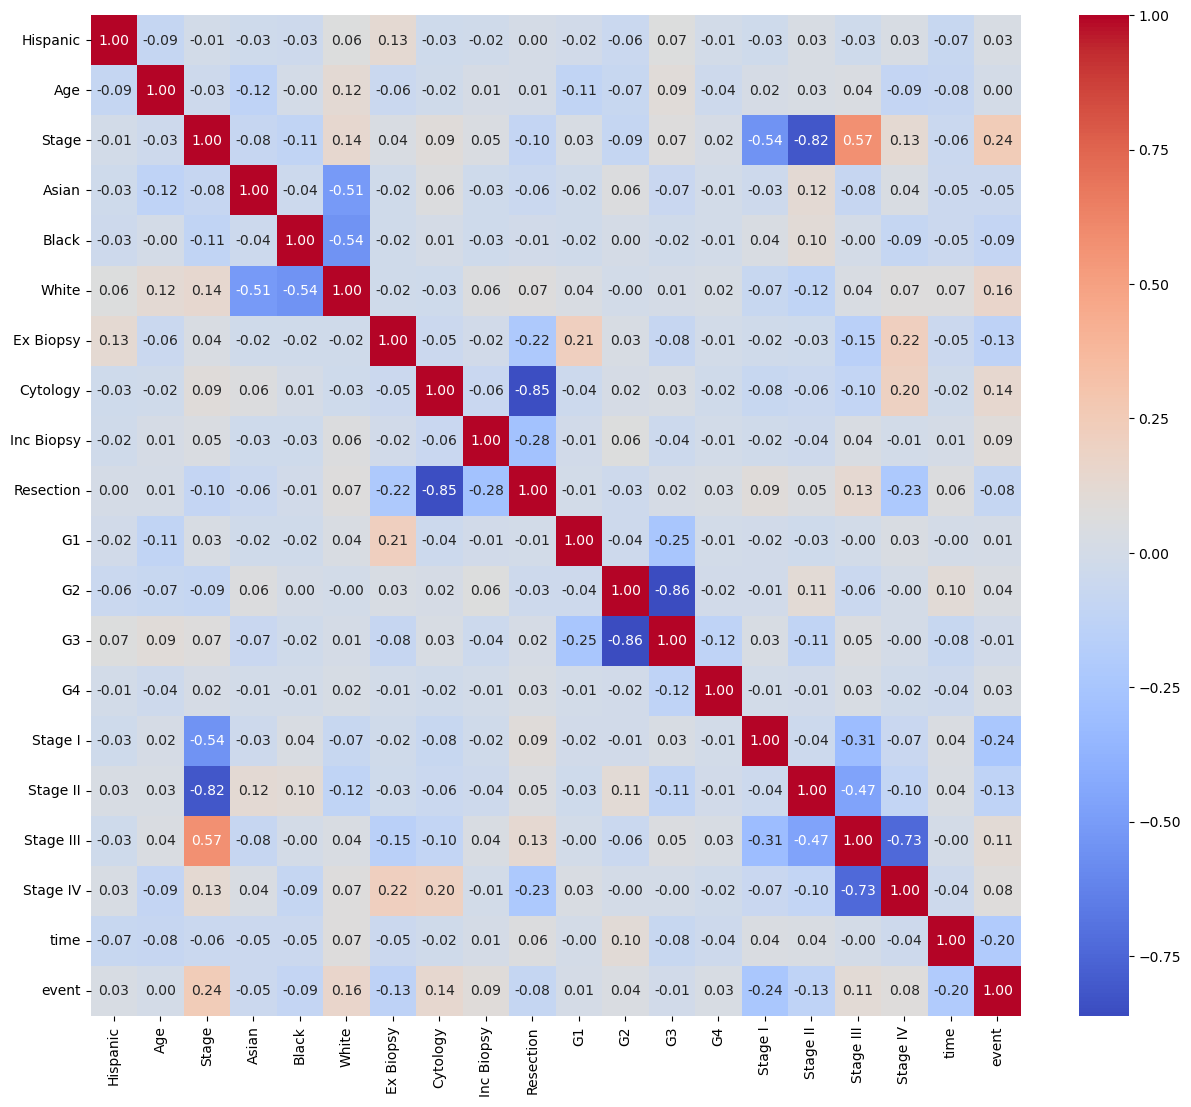

In [15]:
# corr > 0.7 indicates multicollinearity
# https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a#:~:text=Multicollinearity%20is%20a%20situation%20where,indicates%20the%20presence%20of%20multicollinearity.
import matplotlib.pyplot as plt

corr = train_df.corr()


if target_data == "cli":
    ticks = ['Hispanic', 'Age', 'Stage', 'Asian',
       'Black', 'White', 'Ex Biopsy', 'Cytology',
       'Inc Biopsy', 'Resection', 'G1', 'G2',
       'G3', 'G4', 'Stage I', 'Stage II',
       'Stage III', 'Stage IV', 'time', 'event']
    corr.columns = ticks
    corr.index = ticks
    plt.figure(figsize=(15, 13))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

    # plt.show()
    plt.savefig(f"./tcga_ov/figs/cli_hm{surv_type}.png")

    cor_sel = MultiCollinearityEliminator(df=X_train_norm, target=y_train, threshold=.7)
    X_train_reduced = cor_sel.autoEliminateMulticollinearity()
    result_dfs["correlations"] = corr
else:
    print((corr>=.7).sum().sum())
    upper = corr.where(pd.np.triu(pd.np.ones(corr.shape), k=1).astype(bool))
    removed_cols2 = [column for column in upper.columns if any(upper[column] > .7)]
    X_train_reduced = X_train_norm.drop(columns=removed_cols2, axis=1)
print("\tAfter collinearity elimination: ", X_train_reduced.shape)

In [21]:
X_train.columns

Index(['hispanic', 'age', 'stage_binary', 'race_asian', 'race_black',
       'race_white', 'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional',
       'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3',
       'clinical_stage_0.0', 'clinical_stage_1.0', 'clinical_stage_2.0',
       'clinical_stage_3.0'],
      dtype='object')

In [22]:
[i for i in X_train.columns if i not in X_train_reduced.columns]

['biopsy_fnac', 'grade_2', 'clinical_stage_1.0', 'clinical_stage_2.0']

In [44]:
feat_combs["collinreduced"] = X_train_reduced.columns.to_list()
feat_combs["collinreduced"]

['hispanic',
 'age',
 'race_asian',
 'race_black',
 'race_white',
 'biopsy_excisional',
 'biopsy_incisional',
 'biopsy_resection',
 'grade_0',
 'grade_1',
 'grade_3',
 'clinical_stage_0.0',
 'clinical_stage_1.0',
 'clinical_stage_2.0']

## Univariate Analysis

In [25]:
train_data = train_df.copy()

logrank_results = {}
sign_features = []
# Perform univariate analysis for each feature
for feature in X_train_norm.columns:
    # Binarize or categorize the feature (e.g., by median)
    if len(X_train_norm[feature].unique()) > 2:
        train_data["group"] = train_data[feature].apply(lambda x: x > train_data[feature].median())
    else:
        train_data["group"] = train_data[feature].apply(lambda x: x > 0)
    # Survival times and event indicators
    T = train_data['survival_months']
    E = train_data['event']

    # Compare survival distributions
    ix = train_data["group"]
    results = logrank_test(T[ix], T[~ix], event_observed_A=E[ix], event_observed_B=E[~ix])
    
    # logrank_results[feature] = str(round(results.p_value, 4))+"*" if results.p_value < 0.05 else results.p_value
    logrank_results[feature] = results.p_value
    if results.p_value < 0.05:
        sign_features.append(feature)
        kmf = KaplanMeierFitter()
        kmf.fit(T[ix], E[ix], label=f'{feature} high')
        ax = kmf.plot()
        kmf.fit(T[~ix], E[~ix], label=f'{feature} low')
        kmf.plot(ax=ax)
        handles, labels = ax.get_legend_handles_labels()

        # Update labels to desired format
        formatted_labels = [f'{feature.replace("_", " ").capitalize().replace("1.0", "II").replace("3.0", "IV")} low', 
                            '', 
                            f'{feature.replace("_", " ").capitalize().replace("1.0", "II").replace("3.0", "IV")} high', 
                            '']

        # Reassign handles and labels to the legend, skipping the second and fourth items
        plt.legend([handles[0], handles[1]], [formatted_labels[0], formatted_labels[2]])
        plt.ylabel("S(t)", rotation=0,  fontsize=12, labelpad=15)
        plt.xlabel("t", fontsize=12)
        ax.text(0.75, 0.8, f'p-value = {results.p_value:.3f}', transform=ax.transAxes)
        plt.savefig(f'./tcga_ov/figs/km_plot_{feature.replace("0.0", "I").replace("1.0", "II").replace("3.0", "IV")}{surv_type}.png')

        plt.close()
        
    # Store results
    

# Convert results to DataFrame for easier viewing
logrank_results_df = pd.DataFrame.from_dict(logrank_results, orient='index', columns=['p-value'])

print(logrank_results_df.sort_values("p-value"))
len(sign_features)


                         p-value
grade_3             2.151651e-07
stage_binary        5.729793e-04
clinical_stage_0.0  4.559859e-03
hispanic            3.030385e-02
clinical_stage_1.0  3.381833e-02
clinical_stage_3.0  8.336672e-02
grade_2             9.694177e-02
grade_1             1.075064e-01
biopsy_resection    1.770845e-01
age                 1.845374e-01
biopsy_fnac         2.031523e-01
clinical_stage_2.0  2.277798e-01
biopsy_excisional   5.104509e-01
biopsy_incisional   6.351845e-01
race_white          6.550375e-01
grade_0             8.173446e-01
race_asian          9.688675e-01
race_black          9.865689e-01


5

In [24]:

result_dfs["log-rank"] = pd.DataFrame(logrank_results_df)
feat_combs["univariate"] = sign_features
sign_features

['hispanic',
 'stage_binary',
 'grade_3',
 'clinical_stage_0.0',
 'clinical_stage_1.0']

## combinations of univariate fs

In [47]:
def update_combinations(combinations, base, other, third_one=None):
    include = True
    new_set = [i for i in combinations[base] if i in combinations[other]]
    new_name = ("+").join([base, other])
    if third_one:
        new_set = [i for i in new_set if i in combinations[third_one]]
        new_name = ("+").join([base, other, third_one])
    for v in combinations.values():
        if sorted(v) == sorted(new_set):
            include = False
    if include:
        combinations[new_name] = new_set
    return combinations

feat_combs = update_combinations(feat_combs, "highvar", "collinreduced")
feat_combs = update_combinations(feat_combs, "collinreduced", "univariate")
feat_combs = update_combinations(feat_combs, "highvar", "univariate")
feat_combs = update_combinations(feat_combs, "highvar", "collinreduced", "univariate")

for k, v in feat_combs.items():
    print(k, len(v))

all 18
highvar 17
collinreduced 14
univariate 4
highvar+collinreduced 13
collinreduced+univariate 2


In [48]:
for k, v in feat_combs.items():
    for kk, vv in feat_combs.items():
        if sorted(v) == sorted(vv) and k != kk:
            print(k, v)
            print(kk, vv)

## Coxnet with l1 and l2 reg

In [49]:
def coxnet_analysis(X_train, y_train):
    alphas = [1e-3, 1e-2, 0.1]
    # alphas = [1e-2, 0.1]
    while len(alphas)>0:
        try:
            estimator = CoxnetSurvivalAnalysis(alphas=alphas, l1_ratio=.5, fit_baseline_model=True)
            estimator.fit(X_train, y_train)
        except:
            if len(alphas) > 1:
                alphas = alphas[1:]
            else:
                return False
        else:
            break

    # The coefficients of the model can be accessed to determine feature importance
    coefficients = estimator.coef_

    all_feats, selected_alphas = [], []
    for i in range(coefficients.shape[1]):
        print("alpha:", alphas[i])
        selected_features = X_train.columns[coefficients[:, i] != 0]
        selected_features = selected_features.to_list()
        if len(selected_features) > 0 and selected_features not in all_feats:
            all_feats.append(selected_features)
            selected_alphas.append(alphas[i])
            print("Selected features:", selected_features)
    return all_feats, coefficients, alphas, selected_alphas

In [50]:
# all_keys = list(feat_combs.keys())
# for k in all_keys:
#     if "coxnet" in k:
#         feat_combs.pop(k)

In [51]:
alpha_dict = {
    0.001: 0,
    0.01: 1,
    0.1: 2,
}
feat_combs_copy = feat_combs.copy()
for k, v in feat_combs_copy.items():
    coxnet_name = k+"+coxnet" if k != "all" else "coxnet"
    y_train_struct = Surv.from_dataframe('event', 'survival_months', pd.concat([y_train, y_train_event], axis=1))
    
    out = coxnet_analysis(X_train_norm[v], y_train_struct)
    if out != False:
        all_feats, coefficients, alphas, selected_alphas = out
        # print("Nb of features: ", len(all_feats))
        result_dfs[coxnet_name] = pd.DataFrame(coefficients, index=X_train_norm[v].columns, columns=alphas)
        for i in range(len(all_feats)):
            include = True
            for v in feat_combs.values():
                if sorted(all_feats[i]) == sorted(v):
                    include = False
            if include:
                print(i,selected_alphas[i], alpha_dict[selected_alphas[i]])
                feat_combs[f"{coxnet_name}{alpha_dict[selected_alphas[i]]}"] = all_feats[i]

alpha: 0.001
Selected features: ['hispanic', 'age', 'stage_binary', 'race_asian', 'race_black', 'race_white', 'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional', 'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'clinical_stage_1.0', 'clinical_stage_2.0', 'clinical_stage_3.0']
alpha: 0.01
Selected features: ['age', 'stage_binary', 'race_asian', 'race_black', 'race_white', 'biopsy_excisional', 'biopsy_incisional', 'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'clinical_stage_1.0', 'clinical_stage_3.0']
alpha: 0.1
Selected features: ['age', 'stage_binary', 'race_black', 'biopsy_incisional', 'clinical_stage_1.0', 'clinical_stage_3.0']
0 0.001 0
1 0.01 1
2 0.1 2
alpha: 0.001
Selected features: ['hispanic', 'age', 'stage_binary', 'race_asian', 'race_black', 'race_white', 'biopsy_excisional', 'biopsy_fnac', 'biopsy_incisional', 'biopsy_resection', 'grade_0', 'grade_1', 'grade_2', 'clinical_stage_1.0', 'clinical_stage_2.0', 'clinical_stage_3.0']
alpha: 0.0

In [52]:
feat_combs = {target_data+"_"+k: v for k, v in feat_combs.items()}

for k, v in feat_combs.items():
    for kk, vv in feat_combs.items():
        if sorted(v) == sorted(vv) and k != kk:
            print(k, v)
            print(kk, vv)
feat_combs.keys()

dict_keys(['cli_all', 'cli_highvar', 'cli_collinreduced', 'cli_univariate', 'cli_highvar+collinreduced', 'cli_collinreduced+univariate', 'cli_coxnet0', 'cli_coxnet1', 'cli_coxnet2', 'cli_highvar+coxnet0', 'cli_highvar+coxnet1', 'cli_collinreduced+coxnet1', 'cli_collinreduced+coxnet2', 'cli_highvar+collinreduced+coxnet1'])

In [53]:
dname, surv_type

('tcga_ov', '')

In [54]:
with pd.ExcelWriter(f'./{dname}{surv_type}/feat_selection_analysis_{target_data}.xlsx') as writer:
    for name, d in result_dfs.items():
        d.to_excel(writer, sheet_name=name)

In [55]:
backup = feat_combs.copy()

# save to json

In [26]:
if os.path.isfile(f"../splits/{split_name}_{surv_type}/tabular_fs.json"):
    with open(f"../splits/{split_name}_{surv_type}/tabular_fs.json", "r") as f:
        feat_combs_saved = json.load(f)
        feat_combs.update(feat_combs_saved)
        print(f"Loaded {len(feat_combs_saved)} feature combinations.")
        f.close()
with open(f"../splits/{split_name}_{surv_type}/tabular_fs.json", "w") as f:
    json.dump(feat_combs, f)
    f.close()

Loaded 75 feature combinations.


In [27]:
len(feat_combs.keys())

90

In [27]:
feat_combs.keys()

dict_keys(['rna_all', 'rna_highvar', 'rna_collinreduced', 'rna_univariate', 'rna_highvar+collinreduced', 'rna_collinreduced+univariate', 'rna_highvar+univariate', 'rna_highvar+collinreduced+univariate', 'rna_coxnet2', 'rna_highvar+coxnet2', 'rna_collinreduced+coxnet2', 'rna_univariate+coxnet2', 'rna_highvar+collinreduced+coxnet2', 'rna_collinreduced+univariate+coxnet2', 'rna_highvar+univariate+coxnet2', 'rna_highvar+collinreduced+univariate+coxnet2'])

In [27]:
import pandas as pd
dfs = []
for k, v in feat_combs_saved.items():
    dfs.append(pd.DataFrame({}, columns=[k[:3]]))

pro_all 204
pro_collinreduced 186
pro_univariate 23
pro_collinreduced+univariate 21
pro_coxnet0 156
pro_coxnet1 32
pro_collinreduced+coxnet0 182
pro_collinreduced+coxnet1 181
pro_collinreduced+coxnet2 129
pro_univariate+coxnet1 22
pro_univariate+coxnet2 11
pro_collinreduced+univariate+coxnet0 19
pro_collinreduced+univariate+coxnet1 17
pro_collinreduced+univariate+coxnet2 10
rnz_all 20099
rnz_highvar 20098
rnz_collinreduced 15847
rnz_univariate 1079
rnz_highvar+collinreduced 15846
rnz_collinreduced+univariate 877
rnz_coxnet0 189
rnz_collinreduced+coxnet0 181
rnz_univariate+coxnet0 132
rnz_collinreduced+univariate+coxnet0 127
dna_all 14373
dna_highvar 4385
dna_collinreduced 7963
dna_univariate 1030
dna_highvar+collinreduced 3644
dna_collinreduced+univariate 486
dna_highvar+univariate 351
dna_highvar+collinreduced+univariate 229
dna_coxnet0 173
dna_highvar+coxnet0 105
dna_collinreduced+coxnet0 164
dna_univariate+coxnet0 70
dna_highvar+collinreduced+coxnet0 96
dna_collinreduced+univariate+

In [9]:
if os.path.isfile(f"../splits/{dname}/tabular_fs.json"):
    with open(f"../splits/{dname}/tabular_fs.json", "r") as f:
        feat_combs_saved = json.load(f)
len(feat_combs_saved.keys())

102

In [27]:
all_keys = list(feat_combs_saved.keys())
for k in all_keys:
    if "dna_" in k:
        feat_combs_saved.pop(k)

In [29]:
feat_combs_saved.update(feat_combs)

In [26]:
for k in feat_combs.keys():
    print(k, len(feat_combs[k]))

all 18
highvar 17
collinreduced 14
univariate 4
highvar+collinreduced 13
collinreduced+univariate 2
coxnet0 17
coxnet1 13
coxnet2 5
highvar+coxnet0 15
highvar+coxnet1 12
collinreduced+coxnet0 13
collinreduced+coxnet1 13
collinreduced+coxnet2 4
highvar+collinreduced+coxnet0 12
highvar+collinreduced+coxnet1 12


In [31]:
backup.keys

{'cli_all': ['hispanic',
  'age',
  'stage_binary',
  'race_asian',
  'race_black',
  'race_white',
  'biopsy_excisional',
  'biopsy_fnac',
  'biopsy_incisional',
  'biopsy_resection',
  'grade_0',
  'grade_1',
  'grade_2',
  'grade_3',
  'clinical_stage_0.0',
  'clinical_stage_1.0',
  'clinical_stage_2.0',
  'clinical_stage_3.0'],
 'cli_highvar': ['hispanic',
  'age',
  'stage_binary',
  'race_asian',
  'race_black',
  'race_white',
  'biopsy_excisional',
  'biopsy_fnac',
  'biopsy_incisional',
  'biopsy_resection',
  'grade_0',
  'grade_1',
  'grade_2',
  'clinical_stage_0.0',
  'clinical_stage_1.0',
  'clinical_stage_2.0',
  'clinical_stage_3.0'],
 'cli_collinreduced': ['hispanic',
  'age',
  'stage_binary',
  'race_asian',
  'race_black',
  'race_white',
  'biopsy_excisional',
  'biopsy_fnac',
  'biopsy_incisional',
  'grade_0',
  'grade_1',
  'grade_3',
  'clinical_stage_0.0',
  'clinical_stage_2.0'],
 'cli_univariate': ['age',
  'stage_binary',
  'clinical_stage_1.0',
  'clinical

In [40]:
len(feat_combs)

101